In [2]:
from threequbitcode import *
import numpy as np
import time
import matplotlib.pyplot as plt
# Define basis states
ket_0 = np.array([[1], [0]])
ket_1 = np.array([[0], [1]])

# Define Pauli gates
X_gate = np.array([[0, 1], [1, 0]])
Y_gate = np.array([[0,1j],[-1j,0]])
Z_gate = np.array([[1,0],[0,-1]])
Identity = np.identity(2)

#Extra gates
Hadamard = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
                               
#Define CNOT gate
cnot_matrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

# 3 qubit code with coherent errors
Before considering non-unitary errors, let us consider coherent rotations around the x axis:
$$
U = e^{i\theta X} = \cos(\theta)I + i\sin(\theta)X.
$$
Let's then consider our logical error as
$$
U^{\otimes3} = a_0 III + a_1 XII + a_1 IXI + \dots + a_3 XXX.
$$
Where $a_0 = \cos^3(\theta),  a_1 = i\cos^2(\theta)\sin(\theta), a_2 = -\cos{\theta}\sin^2{\theta}, a_3 = -i\sin^3(\theta)$.


So after the error, we're in a superposition of possible all error states, with probabilities given by $c_{\mu}$. So after entangling with ancilla qubits, we will still be in a superposition of the eight basis states, i.e.
$$
|\psi\rangle = a_0|000\rangle \otimes |00\rangle_{\text{ancilla}} + a_1|100\rangle \otimes |10\rangle_{\text{ancilla}} + a_1|010\rangle \otimes |11\rangle_{\text{ancilla}} + \dots + a_3 |111\rangle \otimes |00\rangle_{\text{ancilla}}
$$
But now we can see that measuring our ancilla qubits will collapse the state onto a definite error state, and we can proceed with correcting the error. For example, let's say we encode $|0\rangle_L$ and we measure of ancillas to be $|10\rangle_{\text{ancilla}}$, then our collapsed state is:
$$
\left(a_1|100\rangle + a_2|011\rangle\right)\otimes|10\rangle_{\text{ancilla}}
$$
Hence, after correction and discarding the ancilla qubit, we will be in a superposition of $|0\rangle_L$ and $X_L|0\rangle_L$. Provided $a_1 >> a_2$, the fidelity will be high. We can see that we will only be able to achieve a fidelity of 1 if $\theta = 0$.

So let's now create a function in which we apply random unitary rotations about the x axis (assuming $\theta << 1$).

In [3]:
def three_qubit_x_rotation(encoded_density, theta):
    """Error that rotates the qubit about the x axis"""
    Identity = np.eye(2)  # Define the identity matrix
    X_gate = np.array([[0, 1], [1, 0]])  # Define the Pauli-X gate

    # Define the unitary operation for the rotation
    U = np.cos(theta) * Identity + 1j * np.sin(theta) * X_gate

    # Create the 3-qubit error operation by taking tensor products
    U3 = np.kron(np.kron(U, U), U)

    # Apply the error operation to the density matrix
    error_state = U3 @ encoded_density @ U3.conj().T

    return error_state

We need to modify the measurement function to represent the collapse of the superposition too. To first see how to do this, let's try post selecting just the $1/\sqrt{2}(|00\rangle + |11\rangle)$ Bell state following the measurement of one qubit. 

To define a measurement, we need a set of projection operators $P_i$, one for each possible measurement outcome. The probability of a given density matrix $\rho$ giving outcome $i$ is
$$
p_i=\text{tr}(P_i\rho),
$$
For measurement of a single qubit, the projection operators are $P_0 = |0\rangle\langle0|$ and $P_1 = |1\rangle\langle1|$. So if we measure the second (rightmost) qubit, we expect 
$$p_0 = \text{tr}\left((I \otimes |0\rangle\langle0|) \cdot \rho_{bell}\right) = 1/2$$
We then expect the post measurement (post_selected) outcome to be:

$$
\rho' =\frac{P_i\rho P_i}{p_i}.
$$

In [4]:
bell_state = tensor_product(np.dot(Hadamard, ket_0),ket_0)
bell_state = np.dot(CNOT(0,1,2), bell_state)

bell_rho = state_to_density_matrix(bell_state)

#Define porjection operators to measure the 2nd qubit
P_0 = tensor_product(Identity, np.dot(ket_0, ket_0.T))
P_1 = tensor_product(Identity, np.dot(ket_1, ket_1.T))

#compute porbabilites
prob_0 = np.trace(P_0 @ bell_rho)
prob_1 = np.trace(P_0 @ bell_rho)

# Randomly choose a measurement outcome based on the probabilities
outcomes = ['0', '1']
probabilities = [prob_0, prob_1]
measurement = np.random.choice(outcomes, p=probabilities)
print("Measurement result for second qubit (we'll just assume its 0):", 0, "\n")

#Now we need to post select (just assuming here we measure 0)
post_selected = (P_0 @ bell_rho @ P_0)/prob_0

print("Post selected state: ", post_selected, "\n")

#Partial trace calculation(will link to stack exchange soon...)
reshaped_array = post_selected.reshape([2, 2, 2, 2])

rho_00 = np.einsum('jiki->jk', reshaped_array)

print("Final density matrix", rho_00, "\n")

Measurement result for second qubit (we'll just assume its 0): 0 

Post selected state:  [[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Final density matrix [[1. 0.]
 [0. 0.]] 



We can then expand this for measuring a single qubit in an $n$ qubit state
$$
P_0=|0\rangle\langle 0|\otimes\mathbb{I}^{\otimes(n-1)}\qquad P_1=|1\rangle\langle 1|\otimes\mathbb{I}^{\otimes(n-1)}
$$
Below, we measure the rightmost two (ancilla) qubits from the five (physical + ancilla) qubit state.

In [5]:
def rho_measure_rightmost_2_qubits(rho):
    # Define projection operators for two qubits (assuming ket_0 and ket_1 are defined)
    P_00 = np.kron(ket_0, ket_0).dot(np.kron(ket_0, ket_0).T)
    P_01 = np.kron(ket_0, ket_1).dot(np.kron(ket_0, ket_1).T)
    P_10 = np.kron(ket_1, ket_0).dot(np.kron(ket_1, ket_0).T)
    P_11 = np.kron(ket_1, ket_1).dot(np.kron(ket_1, ket_1).T)
    
    # Tensor projection operators with identity for the 3 leftmost qubits
    I_3 = np.eye(8)  # Identity for 3 qubits
    P_00_full = np.kron(I_3, P_00)
    P_01_full = np.kron(I_3, P_01)
    P_10_full = np.kron(I_3, P_10)
    P_11_full = np.kron(I_3, P_11)
    
    # Compute probabilities for each outcome
    p_00 = np.trace(P_00_full @ rho).real
    p_01 = np.trace(P_01_full @ rho).real
    p_10 = np.trace(P_10_full @ rho).real
    p_11 = np.trace(P_11_full @ rho).real

    # print(p_00, p_01, p_10, p_11)
    # Randomly choose a measurement outcome based on the probabilities
    outcomes = ['00', '01', '10', '11']
    probabilities = [p_00, p_01, p_10, p_11]
    chosen_outcome = np.random.choice(outcomes, p=probabilities)

    
    # Collapse the density matrix onto the chosen outcome
    if chosen_outcome == '00':
        rho_post = (P_00_full @ rho @ P_00_full.T) / p_00
    elif chosen_outcome == '01':
        rho_post = (P_01_full @ rho @ P_01_full.T) / p_01
    elif chosen_outcome == '10':
        rho_post = (P_10_full @ rho @ P_10_full.T) / p_10
    else:  # '11'
        rho_post = (P_11_full @ rho @ P_11_full.T) / p_11
    
    
    return chosen_outcome, rho_post


Now we can plot the fidelity of the 3 qubit bit-flip code following various rotations about the $x$ axis of the bloch sphere.

Time taken:  48.73733568191528


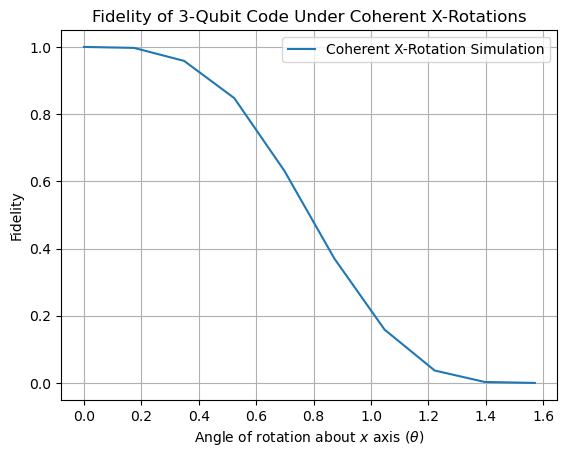

In [6]:
def coherent_error_3_qubit_sim(theta, repetitions=1000):
    fidelities = 0
    for _ in range(repetitions):
        initial_density_matrix = state_to_density_matrix(ket_0)
        encoded_density = encode_logical_density_matrix(initial_density_matrix)
        error_applied_density = three_qubit_x_rotation(encoded_density, theta)
        ancilla_added_density = rho_add_ancilla_qubits(error_applied_density)
        result, rho_post = rho_measure_rightmost_2_qubits(ancilla_added_density)
        corrected_density = rho_correct_density_matrix(rho_post, result)
        reshaped_array = corrected_density.reshape([8, 4, 8, 4])
        final_density = np.einsum('jiki->jk', reshaped_array)
        fidelities += np.real(fidelity(encoded_density, final_density))

    return fidelities / repetitions

start_time = time.time()

# Now usefor various angles of rotation and plot the result
thetas = np.linspace(0, np.pi/2, 10)  # Angles from 0 to pi/2 radians
simulated_fidelities = [coherent_error_3_qubit_sim(theta) for theta in thetas]

end_time = time.time()

print("Time taken: ", end_time - start_time)
# Plot the results
plt.plot(thetas, simulated_fidelities, label='Coherent X-Rotation Simulation')
plt.xlabel('Angle of rotation about $x$ axis $(\\theta)$')
plt.ylabel('Fidelity')
plt.title('Fidelity of 3-Qubit Code Under Coherent X-Rotations')
plt.legend()
plt.grid(True)
plt.show()

We can now also see how the fidelity of a logical state changes over many cycles for a fixed angle of rotation about the $x$ axis of the Bloch sphere

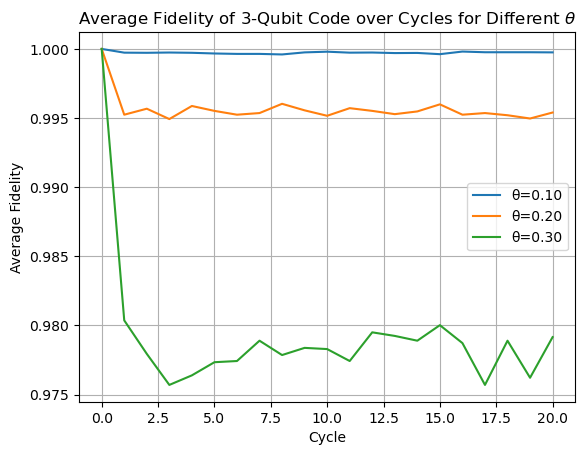

In [7]:
def coherent_error_3_qubit_cycle_sim(theta, cycles=100, repetitions=1000):
    average_fidelities = np.zeros(cycles + 1)  # Initialize average fidelities to zero
    
    for _ in range(repetitions):
        # Generate initial states
        initial_density_matrix = state_to_density_matrix(ket_0)
        encoded_density = encode_logical_density_matrix(initial_density_matrix)
        
        fidelities = [1.0]  # Start with fidelity of 1 for the initial state
        current_density = encoded_density

        # Loop over cycles
        for cycle in range(cycles):
            error_applied_density = three_qubit_x_rotation(encoded_density, theta)
            ancilla_added_density = rho_add_ancilla_qubits(error_applied_density)
            result, rho_post = rho_measure_rightmost_2_qubits(ancilla_added_density)
            corrected_density = rho_correct_density_matrix(rho_post, result)
            reshaped_array = corrected_density.reshape([8, 4, 8, 4])
            current_density = np.einsum('jiki->jk', reshaped_array)
            fidelity_value = np.real(fidelity(encoded_density, current_density))
            fidelities.append(fidelity_value)
        
        # Add the fidelities from this repetition to the running total
        average_fidelities += np.array(fidelities)
    
    # Calculate the average fidelities over all repetitions
    average_fidelities /= repetitions
    return average_fidelities

# Range of theta values
theta_values = [0.1, 0.2, 0.3]  
cycles = 20  # Number of cycles
repetitions = 1000  # Number of repetitions for averaging

start_time = time.time()
# Plot the results for each theta
for theta in theta_values:
    avg_fidelity_over_cycles = coherent_error_3_qubit_cycle_sim(theta, cycles, repetitions)
    plt.plot(range(cycles+1), avg_fidelity_over_cycles, label=f'θ={theta:.2f}')

end_time = time.time()

plt.xlabel('Cycle')
plt.ylabel('Average Fidelity')
plt.title('Average Fidelity of 3-Qubit Code over Cycles for Different $\\theta$')
plt.legend()
plt.grid(True)
plt.show()

